### Co-authored by Martin Beck, Yeggi Lee, Tanvi Modi, Sasha Opela, Jackson Ross, Matt Zlotnik as a result of our Business Data Science final project.

Based on Data set from UCI's Machine Learning Repository https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score, train_test_split, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
!pip install xgboost
import xgboost as xgb
from xgboost import XGBClassifier

## Reading Data

In [3]:
# Reading shopping data
X_train = pd.read_csv('ShoppingData.csv')
df = X_train.copy()
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


## Producing dummy variables for categorical data and cleaning data

In [4]:
dummiesdf = pd.get_dummies(df['VisitorType'])
df.drop('VisitorType', inplace = True, axis = 1)
df['New_Visitor'] = dummiesdf['New_Visitor']
df['Other'] = dummiesdf['Other']
df['Returning_Visitor'] = dummiesdf['Returning_Visitor']

In [5]:
dfmonth = pd.get_dummies(df['Month']) 
df.drop('Month', inplace = True, axis = 1)
dfwithdummies = pd.concat([df, dfmonth], axis = 1, sort = False)

In [6]:
dfwithdummies['Class'] = df['Revenue'].astype(int)
dfwithdummies.drop('Revenue', axis = 1, inplace = True)
dfwithdummies['Weekend'] = df['Weekend'].astype(int)
dfwithdummies.drop('Returning_Visitor', axis = 1, inplace = True)
dfcleaned = dfwithdummies.copy()

In [7]:
X = dfcleaned.drop('Class', axis = 1)
Y = dfcleaned['Class'].copy()

## Checking for Collinearity Between Features and Creating Reducing Feature Size

In [8]:
cor = X.corr()

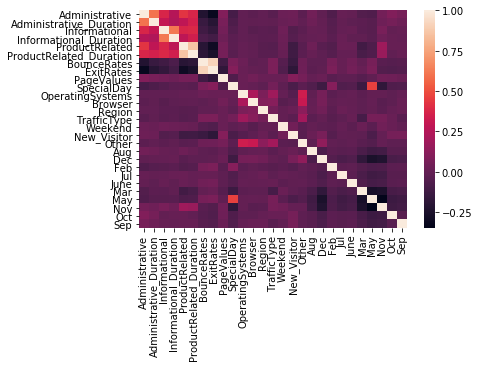

In [9]:
sns.heatmap(cor, xticklabels=cor.columns,yticklabels=cor.columns)

In [10]:
# dfcleaned[dfcleaned['New_Visitor'] == 1]['Administrative'].value_counts()
def AvgMinutes(Count, Duration):
    if Duration == 0:
        output = 0
    elif Duration != 0:
        output = float(Duration)/float(Count)
    return output
    
Columns = [['Administrative', 'Administrative_Duration'], ['Informational', 'Informational_Duration'], ['ProductRelated', 'ProductRelated_Duration']]
    
    
X['AvgAdministrative'] = X.apply(lambda x: AvgMinutes(Count = x['Administrative'], Duration = x['Administrative_Duration']), axis = 1)
X['AvgInformational'] = X.apply(lambda x: AvgMinutes(Count = x['Informational'], Duration = x['Informational_Duration']), axis = 1)
X['AvgProductRelated'] = X.apply(lambda x: AvgMinutes(Count = x['ProductRelated'], Duration = x['ProductRelated_Duration']), axis = 1)
X.drop(['Administrative', 'Administrative_Duration','Informational', 'Informational_Duration','ProductRelated', 'ProductRelated_Duration'], axis = 1, inplace = True)

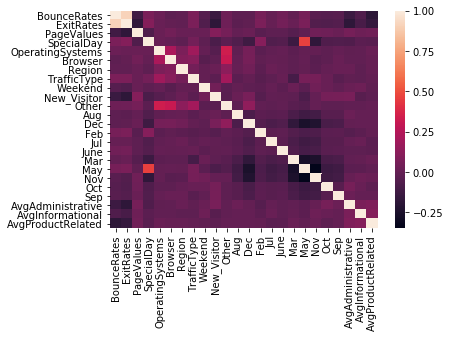

In [11]:
cor = X.corr()
sns.heatmap(cor, xticklabels=cor.columns,yticklabels=cor.columns)

## Quick overview of features

C:\Users\marti\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<Figure size 432x288 with 0 Axes>

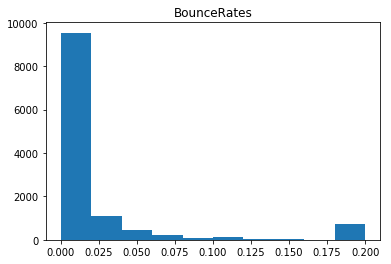

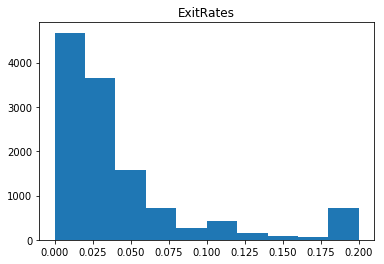

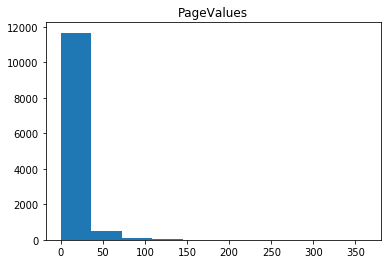

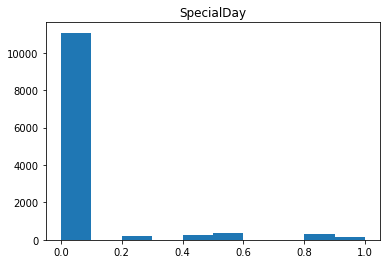

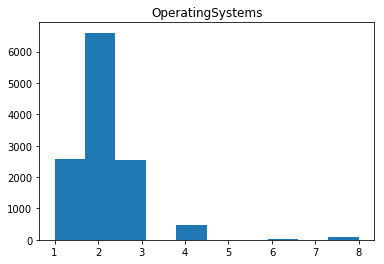

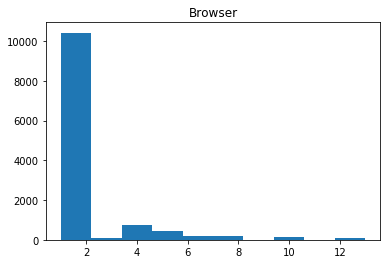

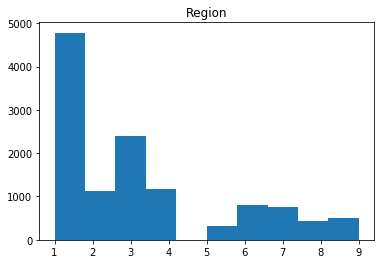

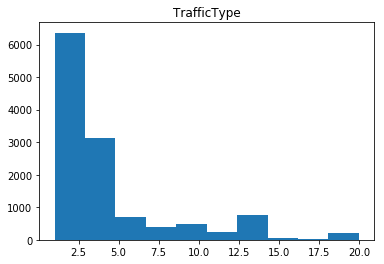

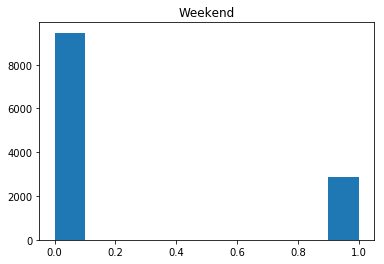

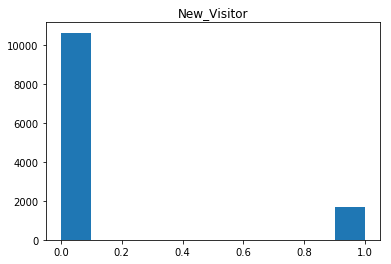

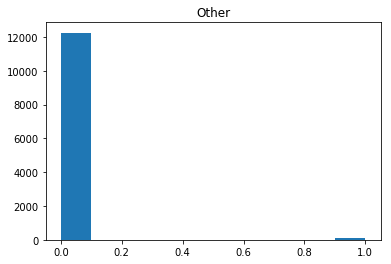

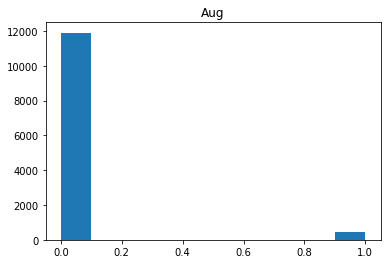

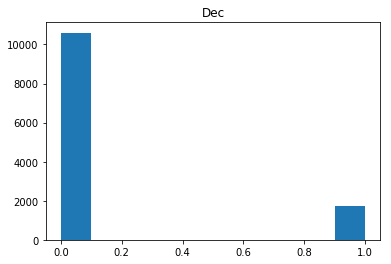

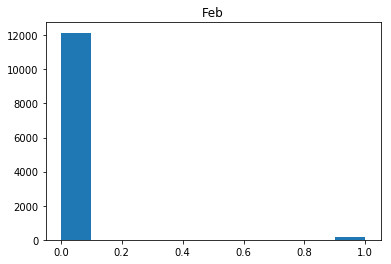

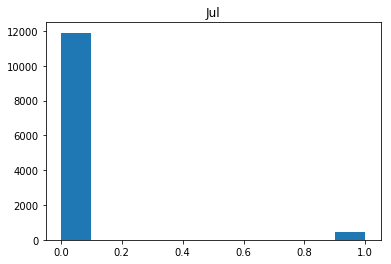

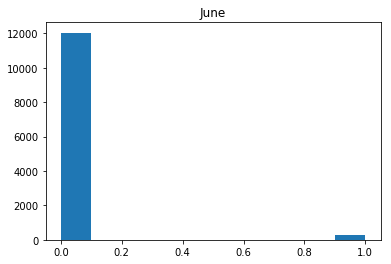

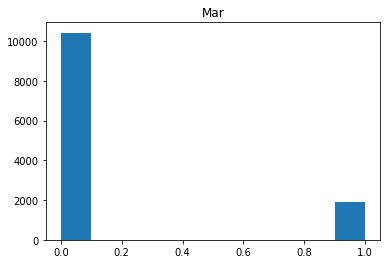

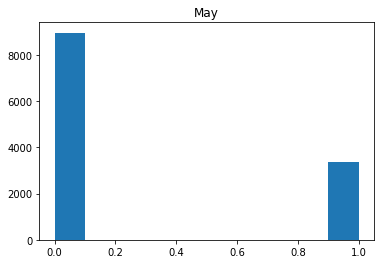

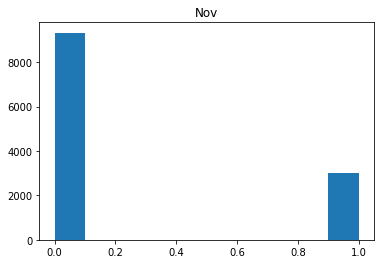

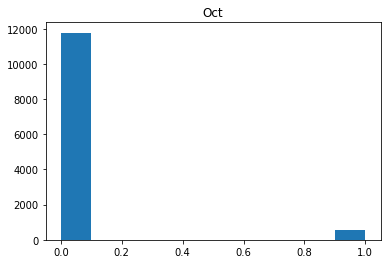

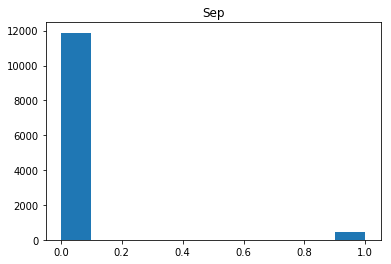

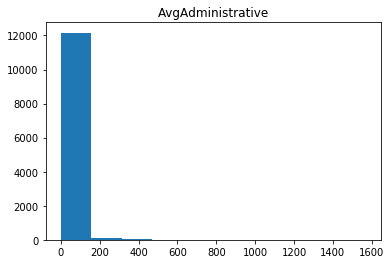

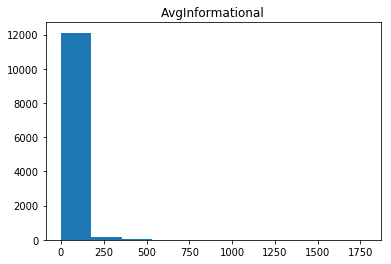

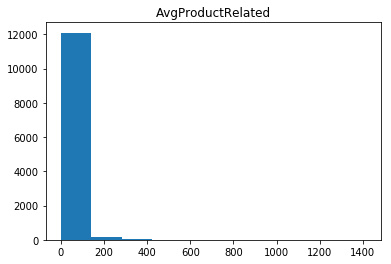

In [12]:
# Histogram of all features
for idx,column in enumerate(X.columns): 
    plt.figure(idx)
    X.hist(column=column,grid=False)

In [13]:
# Checking for NA values
for i in X.columns:
    print('Feature:',i)
    print('# of N/A:',X[i].isna().sum())

Feature: BounceRates
# of N/A: 0
Feature: ExitRates
# of N/A: 0
Feature: PageValues
# of N/A: 0
Feature: SpecialDay
# of N/A: 0
Feature: OperatingSystems
# of N/A: 0
Feature: Browser
# of N/A: 0
Feature: Region
# of N/A: 0
Feature: TrafficType
# of N/A: 0
Feature: Weekend
# of N/A: 0
Feature: New_Visitor
# of N/A: 0
Feature: Other
# of N/A: 0
Feature: Aug
# of N/A: 0
Feature: Dec
# of N/A: 0
Feature: Feb
# of N/A: 0
Feature: Jul
# of N/A: 0
Feature: June
# of N/A: 0
Feature: Mar
# of N/A: 0
Feature: May
# of N/A: 0
Feature: Nov
# of N/A: 0
Feature: Oct
# of N/A: 0
Feature: Sep
# of N/A: 0
Feature: AvgAdministrative
# of N/A: 0
Feature: AvgInformational
# of N/A: 0
Feature: AvgProductRelated
# of N/A: 0


In [14]:
for i in X_train.columns:
    print('####################')
    print('COLUMN TITLE:',i)
    print('# UNIQUE VALUES:',len(X_train[i].unique()))
    print('UNIQUE VALUES:',X_train[i].unique())
    print('####################')
    print()

####################
COLUMN TITLE: Administrative
# UNIQUE VALUES: 27
UNIQUE VALUES: [ 0  1  2  4 12  3 10  6  5  9  8 16 13 11  7 18 14 17 19 15 24 22 21 20
 23 27 26]
####################

####################
COLUMN TITLE: Administrative_Duration
# UNIQUE VALUES: 3335
UNIQUE VALUES: [  0.         53.         64.6       ... 167.9107143 305.125
 150.3571429]
####################

####################
COLUMN TITLE: Informational
# UNIQUE VALUES: 17
UNIQUE VALUES: [ 0  1  2  4 16  5  3 14  6 12  7  9 10  8 11 24 13]
####################

####################
COLUMN TITLE: Informational_Duration
# UNIQUE VALUES: 1258
UNIQUE VALUES: [  0.   120.    16.   ... 547.75 368.25 211.25]
####################

####################
COLUMN TITLE: ProductRelated
# UNIQUE VALUES: 311
UNIQUE VALUES: [  1   2  10  19   0   3  16   7   6  23  13  20   8   5  32   4  45  14
  52   9  46  15  22  11  12  36  42  27  90  18  38  17 128  25  30  21
  51  26  28  31  24  50  96  49  68  98  67  55  35  37  29

C:\Users\marti\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<Figure size 432x288 with 0 Axes>

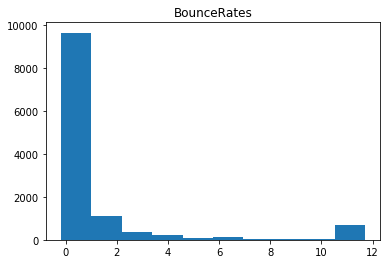

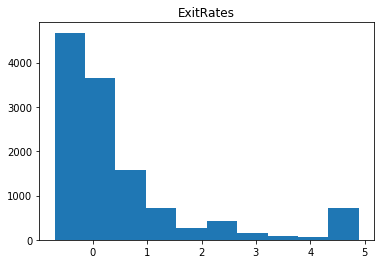

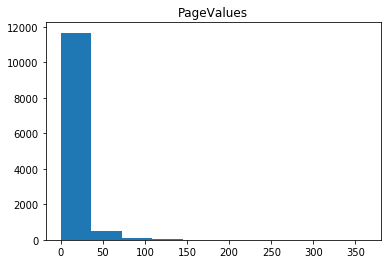

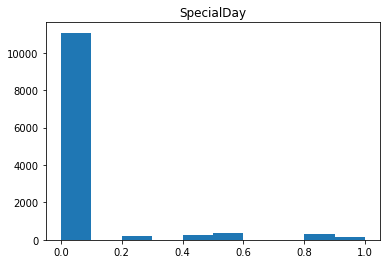

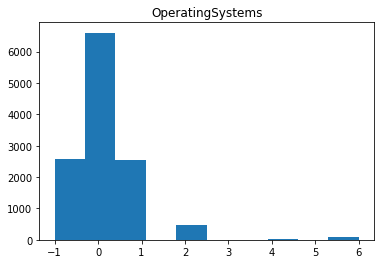

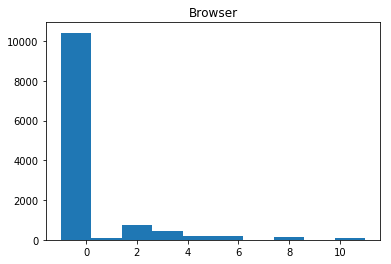

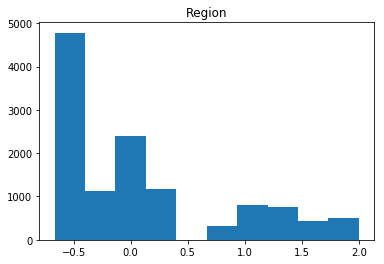

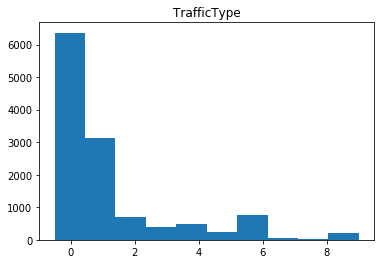

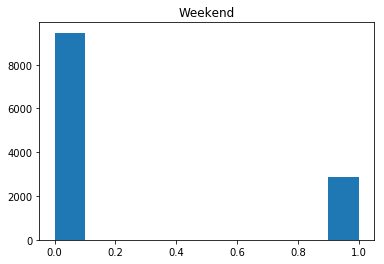

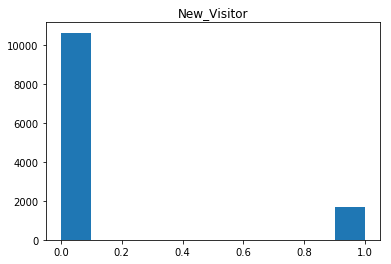

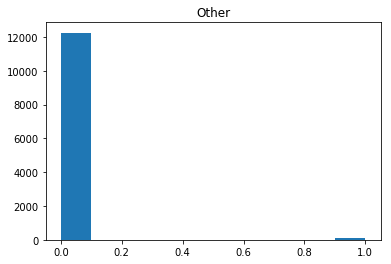

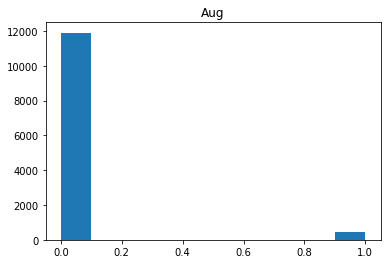

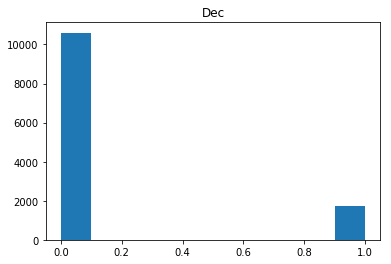

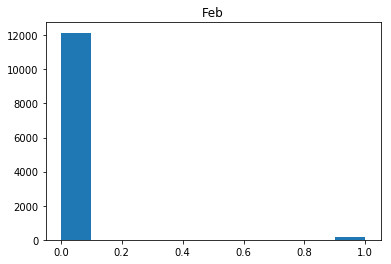

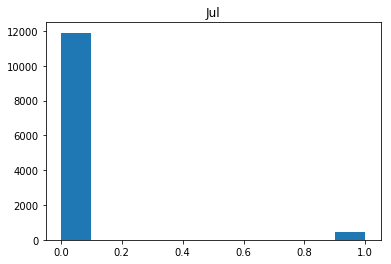

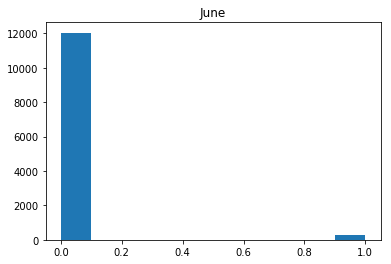

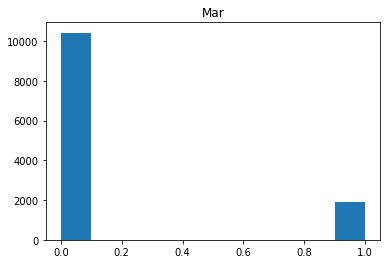

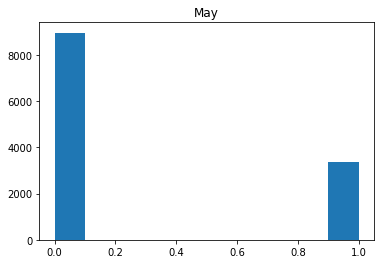

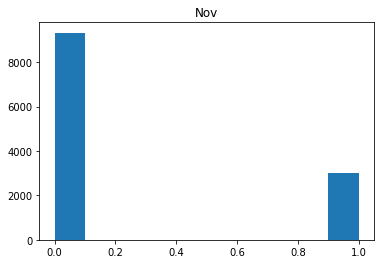

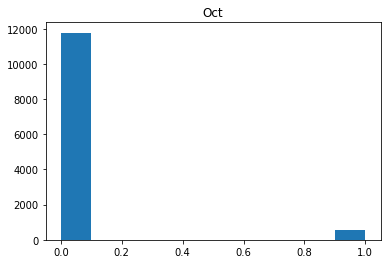

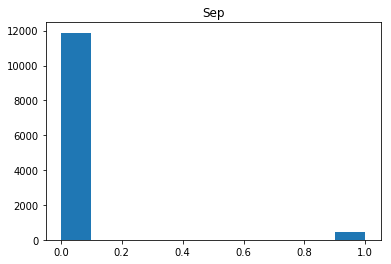

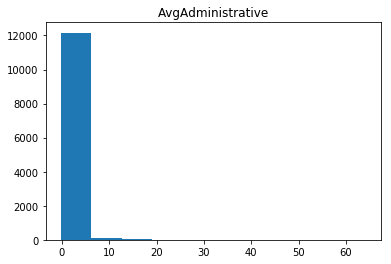

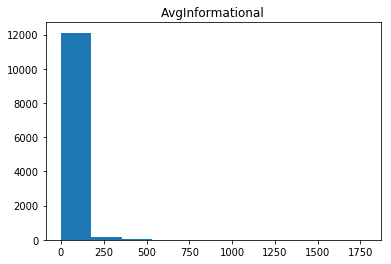

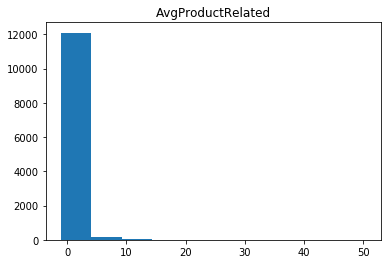

In [15]:
# Scaling to normalize data
X_copy = X.copy()
rc = RobustScaler()
X_rc=rc.fit_transform(X_copy)
X_rc=pd.DataFrame(X_rc,columns=X.columns)

for idx,column in enumerate(X_rc.columns):
    plt.figure(idx)
    X_rc.hist(column=column,grid=False)

## Linear Model with All Features

In [18]:
from sklearn import linear_model
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(X_rc,Y,test_size=.2)

In [19]:
# Linear model
model = linear_model.SGDClassifier()
model.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [20]:
y_pred = model.predict(X_test)

In [21]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.8771289537712895

In [22]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_pred)

0.7662693098665646

## Random Forest with all Features

In [26]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=17, random_state=0)
clf.fit(X_train, y_train)
y_pred1 = clf.predict(X_test)

C:\Users\marti\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [27]:
accuracy_score(y_test, y_pred1)

0.8872668288726683

In [46]:
roc_auc_score(y_test, y_pred1)

0.7298184992108661

## Finding Important Features then Removing from Dataframe

In [29]:
from sklearn import svm
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
list_one =[]
feature_ranking = SelectKBest(chi2, k=5)
fit = feature_ranking.fit(X, Y)

fmt = '%-8s%-20s%s'

for i, (score, feature) in enumerate(zip(feature_ranking.scores_, X.columns)):
    list_one.append((score, feature))
    
dfObj = pd.DataFrame(list_one) 
dfObj.sort_values(by=[0], ascending = False)

,0,1
2,175126.808512,PageValues
22,10662.599140,AvgInformational
21,6829.412944,AvgAdministrative
23,1143.263922,AvgProductRelated
18,223.548231,Nov
9,115.339482,New_Visitor
17,54.997108,May
3,53.797094,SpecialDay
16,42.613274,Mar
0,29.654336,BounceRates


In [34]:
X_rc.drop(['Aug','TrafficType','OperatingSystems','Other','Jul'],axis=1,inplace=True)

In [35]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_rc,Y,test_size=.2)

## Random Forest Classifier with Feature Selection Dataframe

In [36]:
clf1 = RandomForestClassifier(n_estimators= 200, max_depth = 30 )
clf1.fit(X_train1, y_train1)
y_pred2 = clf1.predict(X_test1)

In [39]:
accuracy_score(y_test1, y_pred2)

0.8994322789943228

In [40]:
roc_auc_score(y_test1, y_pred2)

0.7710647802865168

## XGBoost Classifier with Feature Selection Dataframe

In [47]:
model = XGBClassifier(learning_rate = 0.1, n_estimators=150, min_child_weight=3,  max_depth=13)
model.fit(X_train1, y_train1)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=13,
              min_child_weight=3, missing=None, n_estimators=150, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [48]:
y_pred3 = model.predict(X_test1)

In [49]:
accuracy_score(y_test1, y_pred3)

0.8937550689375506

In [50]:
roc_auc_score(y_test1, y_pred3)

0.7730314657133652